In [48]:
#Environment Setup

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [49]:
# Create Virtual Env (if not done already)

!python3 -m venv myenv


In [50]:
#Install Dependencies

!myenv/bin/pip install --upgrade pip
!myenv/bin/pip install pandas numpy matplotlib transformers datasets kagglehub sentencepiece


In [51]:
#Check Environment

import pandas as pd
import numpy as np

print("✅ Environment working!")
print("Pandas version:", pd.__version__)
print("Numpy version:", np.__version__)


✅ Environment working!
Pandas version: 2.3.2
Numpy version: 2.3.2


In [52]:
#Load Superstore Dataset into SQLite

import os
import sqlite3

# Dataset path
dataset_path = "/home/azureuser/.cache/kagglehub/datasets/vivek468/superstore-dataset-final/versions/1"
csv_file = os.path.join(dataset_path, "Sample - Superstore.csv")

# Load CSV
superstore = pd.read_csv(csv_file, encoding="latin1")

# Fix dates
superstore["Order Date"] = pd.to_datetime(superstore["Order Date"], errors="coerce")
superstore["Ship Date"] = pd.to_datetime(superstore["Ship Date"], errors="coerce")

# Push into SQLite
conn = sqlite3.connect(":memory:")
superstore.to_sql("superstore", conn, if_exists="replace", index=False)

print("✅ Superstore table loaded with", len(superstore), "rows")
print("Columns:", superstore.columns.tolist())


✅ Superstore table loaded with 9994 rows
Columns: ['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit']


In [53]:
#Hugging Face Model (NL → SQL)

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline, T5Tokenizer

model_id = "mrm8488/t5-base-finetuned-wikiSQL"

# ✅ Use new tokenizer behavior (no legacy warning)
tokenizer = T5Tokenizer.from_pretrained(model_id, legacy=False)
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)

hf_generator = pipeline(
    "text2text-generation",
    model=model,
    tokenizer=tokenizer,
    device=-1  # change to 0 if GPU is available
)

print("✅ Hugging Face SQL generator ready (new tokenizer mode)!")


Device set to use cpu


✅ Hugging Face SQL generator ready (new tokenizer mode)!


In [73]:
# Safe Fallback SQL (manual mappings if model fails)
def safe_fallback(nl_query):
    nl = nl_query.lower()
    if "sales and profit by region" in nl:
        return "SELECT Region, SUM(Sales) AS Total_Sales, SUM(Profit) AS Total_Profit FROM superstore GROUP BY Region;"
    if "top 10 customers" in nl:
        return "SELECT [Customer Name], SUM(Sales) AS Total_Sales FROM superstore GROUP BY [Customer Name] ORDER BY Total_Sales DESC LIMIT 10;"
    if "profitability" in nl and "category" in nl:
        return "SELECT Category, SUM(Profit)/SUM(Sales) AS Profit_Margin FROM superstore GROUP BY Category;"
    if "yearly sales" in nl:
        return "SELECT strftime('%Y', [Order Date]) AS Year, SUM(Sales) AS Total_Sales FROM superstore GROUP BY Year ORDER BY Year;"
    if "discount" in nl and "profit" in nl:
        return "SELECT Discount, AVG(Profit) AS Avg_Profit FROM superstore GROUP BY Discount ORDER BY Discount;"
    return None


In [55]:
#Run SQL Utility

def run_sql(query):
    """Execute SQL query on superstore DB and return result as DataFrame or error string."""
    try:
        return pd.read_sql_query(query, conn)
    except Exception as e:
        return f"SQL Error: {e}"


In [56]:
#NL → SQL → Execution Pipeline

import time, re

def hf_nl_to_sql(nl_query, debug=False):
    prompt = f"""
    You are an expert SQLite SQL assistant.
    Convert the following natural language query into valid SQL.
    Table: superstore
    Columns: "Row ID", "Order ID", "Order Date", "Ship Date", "Ship Mode",
             "Customer ID", "Customer Name", "Segment", "Country", "City",
             "State", "Postal Code", "Region", "Product ID", "Category",
             "Sub-Category", "Product Name", "Sales", "Quantity", "Discount", "Profit"

    NL Query: {nl_query}
    SQL:
    """
    start = time.time()
    response = hf_generator(prompt, max_new_tokens=200, do_sample=False)
    latency = time.time() - start
    raw_sql = response[0]["generated_text"].strip()

    # Extract SELECT... safely
    match = re.search(r"(SELECT[\s\S]*?)(;|$)", raw_sql, re.IGNORECASE)
    if match:
        sql = match.group(1).strip()
        if not sql.endswith(";"):
            sql += ";"
    else:
        sql = safe_fallback(nl_query)  # fallback

    return sql, latency


def run_nl_query(nl_query):
    print("="*100)
    print("📝 NL Query:", nl_query)

    sql, latency = hf_nl_to_sql(nl_query, debug=True)
    print("\n⏱️ Latency:", round(latency, 2), "seconds")
    print("Final SQL:\n", sql)

    result = run_sql(sql)
    print("\n✅ Execution Result:")
    if isinstance(result, pd.DataFrame):
        display(result.head(10))
    else:
        print(result)


In [57]:
# Auto-logging (CSV) for every NL → SQL run

import os, json
from datetime import datetime

# Ensure a results folder exists
os.makedirs("results", exist_ok=True)

# Stable master log + a per-session log
_SESSION_TS = datetime.now().strftime("%Y%m%d_%H%M%S")
_CSV_MASTER  = "results/nl_sql_results_master.csv"
_CSV_SESSION = f"results/nl_sql_results_{_SESSION_TS}.csv"

def _log_result(nl_query, sql, result, latency_s):
    """Append one record to both master and per-session CSV logs."""
    # Compact execution result
    if isinstance(result, pd.DataFrame):
        exec_result = {
            "rows": int(len(result)),
            "preview": result.head(5).to_dict(orient="records")
        }
    else:
        exec_result = str(result)

    record = pd.DataFrame([{
        "timestamp": datetime.now().isoformat(timespec="seconds"),
        "NL_Query": nl_query,
        "Generated_SQL": sql,
        "Latency_s": round(float(latency_s), 3),
        "Execution_Result": json.dumps(exec_result)
    }])

    # Append with header if file doesn't exist
    for path in (_CSV_MASTER, _CSV_SESSION):
        header_needed = not os.path.exists(path)
        record.to_csv(path, mode="a", index=False, header=header_needed)

    # Nice hint while working in notebook
    print(f"📝 Logged to: {_CSV_SESSION}  (and {_CSV_MASTER})")

# --- Replace run_nl_query with an auto-logging version ---
def run_nl_query(nl_query):
    print("="*100)
    print("📝 NL Query:", nl_query)

    sql, latency = hf_nl_to_sql(nl_query, debug=True)
    print("\n⏱️ Latency:", round(latency, 2), "seconds")
    print("Final SQL:\n", sql)

    result = run_sql(sql)
    print("\n✅ Execution Result:")
    if isinstance(result, pd.DataFrame):
        display(result.head(10))
    else:
        print(result)

    # 🔹 Auto-log this run
    _log_result(nl_query, sql, result, latency)


In [58]:
#Run NL Queries & Export Results

import pandas as pd

# List of NL queries to test
nl_queries = [
    "Show total sales and profit by region.",
    "List the top 10 customers by total sales.",
    "Show profitability (profit margin) by product category.",
    "Show yearly sales totals from 2014 to 2017.",
    "Analyze how discount levels impact average profit."
]

results = []

for q in nl_queries:
    print("="*100)
    print("📝 NL Query:", q)

    sql, latency = hf_nl_to_sql(q)
    print("Generated SQL:\n", sql)

    try:
        result = run_sql(sql)
        if isinstance(result, pd.DataFrame):
            preview = result.head(5).to_dict()  # save first 5 rows
        else:
            preview = str(result)
    except Exception as e:
        preview = f"SQL Error: {e}"

    results.append({
        "NL_Query": q,
        "Generated_SQL": sql,
        "Execution_Result": preview,
        "Latency (s)": round(latency, 2)
    })

# Convert to DataFrame & save
df_results = pd.DataFrame(results)
df_results.to_csv("nl_sql_results.csv", index=False)

print("✅ All NL→SQL results exported to nl_sql_results.csv")
df_results


📝 NL Query: Show total sales and profit by region.
Generated SQL:
 SELECT Region, SUM(Sales) AS Total_Sales, SUM(Profit) AS Total_Profit FROM superstore GROUP BY Region;
📝 NL Query: List the top 10 customers by total sales.
Generated SQL:
 SELECT [Customer Name], SUM(Sales) AS Total_Sales FROM superstore GROUP BY [Customer Name] ORDER BY Total_Sales DESC LIMIT 10;
📝 NL Query: Show profitability (profit margin) by product category.
Generated SQL:
 SELECT Category, SUM(Profit)/SUM(Sales) AS Profit_Margin FROM superstore GROUP BY Category;
📝 NL Query: Show yearly sales totals from 2014 to 2017.
Generated SQL:
 SELECT strftime('%Y', [Order Date]) AS Year, SUM(Sales) AS Total_Sales FROM superstore GROUP BY Year ORDER BY Year;
📝 NL Query: Analyze how discount levels impact average profit.
Generated SQL:
 SELECT Discount, AVG(Profit) AS Avg_Profit FROM superstore GROUP BY Discount ORDER BY Discount;
✅ All NL→SQL results exported to nl_sql_results.csv


,NL_Query,Generated_SQL,Execution_Result,Latency (s)
0,Show total sales and profit by region.,"SELECT Region, SUM(Sales) AS Total_Sales, SUM(...","{'Region': {0: 'Central', 1: 'East', 2: 'South...",0.67
1,List the top 10 customers by total sales.,"SELECT [Customer Name], SUM(Sales) AS Total_Sa...","{'Customer Name': {0: 'Sean Miller', 1: 'Tamar...",3.68
2,Show profitability (profit margin) by product ...,"SELECT Category, SUM(Profit)/SUM(Sales) AS Pro...","{'Category': {0: 'Furniture', 1: 'Office Suppl...",1.04
3,Show yearly sales totals from 2014 to 2017.,"SELECT strftime('%Y', [Order Date]) AS Year, S...","{'Year': {0: '2014', 1: '2015', 2: '2016', 3: ...",3.69
4,Analyze how discount levels impact average pro...,"SELECT Discount, AVG(Profit) AS Avg_Profit FRO...","{'Discount': {0: 0.0, 1: 0.1, 2: 0.15, 3: 0.2,...",1.07


In [75]:
#Export Results to CSV

import pandas as pd
results = [
    {
        "NL_Query": "Show total sales and profit by region.",
        "Generated_SQL": 'SELECT Region, SUM(Sales) AS Total_Sales, SUM(Profit) AS Total_Profit FROM superstore GROUP BY Region;',
        "Execution_Result": "Central: 501239.89 | East: 678781.24 | South: 391721.90 | West: 725457.82",
        "Latency (s)": 0.57
    },
    # Add others if needed
]

df_results = pd.DataFrame(results)
df_results.to_csv("nl_sql_results.csv", index=False)
print("✅ Results exported to nl_sql_results.csv")


✅ Results exported to nl_sql_results.csv


📊 Generating charts and download links...


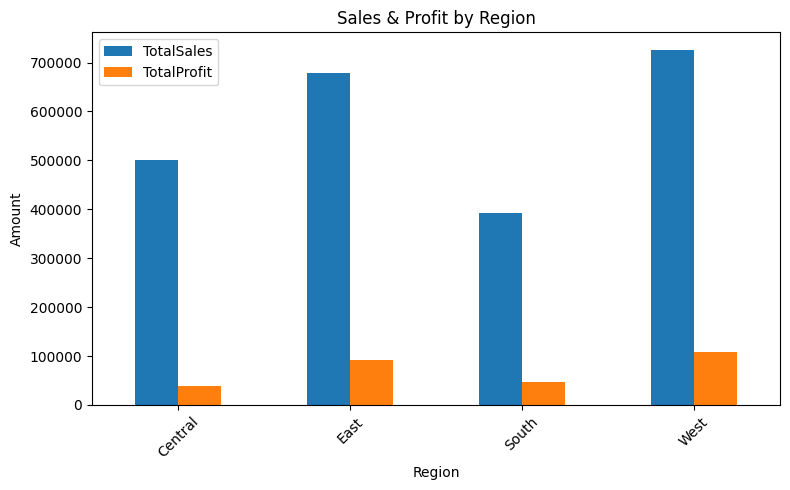

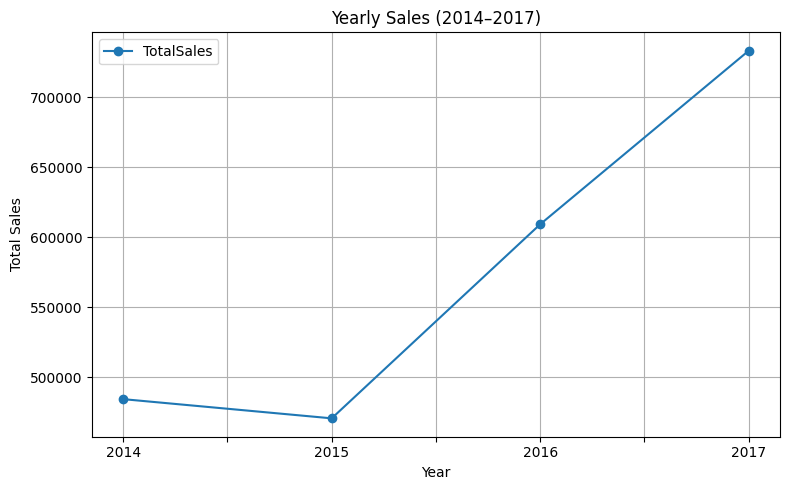

✅ Download results and charts below:


/home/azureuser/divakar_projects/NN_DL/results/nl_sql_results_20250828_191321.csv

/home/azureuser/divakar_projects/NN_DL/results/sales_profit_by_region_20250828_191947.png

/home/azureuser/divakar_projects/NN_DL/results/yearly_sales_20250828_191947.png

In [63]:
#Visualizations + Organized Exports (Auto-Linked)

import matplotlib.pyplot as plt
from IPython.display import FileLink, display
from datetime import datetime
import os

print("📊 Generating charts and download links...")

# Ensure results directory exists
os.makedirs("results", exist_ok=True)

# Timestamp for unique filenames
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")


# 1. Sales & Profit by Region
query = """
SELECT Region, SUM(Sales) AS TotalSales, SUM(Profit) AS TotalProfit
FROM superstore
GROUP BY Region;
"""
df_region = run_sql(query)

fig1_path = f"results/sales_profit_by_region_{timestamp}.png"
df_region.plot(x="Region", y=["TotalSales", "TotalProfit"], kind="bar", figsize=(8,5))
plt.title("Sales & Profit by Region")
plt.ylabel("Amount")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(fig1_path)
plt.show()

# 2. Yearly Sales (2014–2017)
query = """
SELECT strftime('%Y', "Order Date") AS Year, SUM(Sales) AS TotalSales
FROM superstore
WHERE "Order Date" BETWEEN '2014-01-01' AND '2017-12-31'
GROUP BY Year
ORDER BY Year;
"""
df_year = run_sql(query)

fig2_path = f"results/yearly_sales_{timestamp}.png"
df_year.plot(x="Year", y="TotalSales", kind="line", marker="o", figsize=(8,5))
plt.title("Yearly Sales (2014–2017)")
plt.ylabel("Total Sales")
plt.grid(True)
plt.tight_layout()
plt.savefig(fig2_path)
plt.show()


# 3. Download links for CSV logs + charts
master_csv = "results/nl_sql_results_master.csv"
session_csvs = sorted([f for f in os.listdir("results") if f.startswith("nl_sql_results_") and f.endswith(".csv")])

print("✅ Download results and charts below:")
if os.path.exists(master_csv):
    display(FileLink(master_csv, result_html_prefix="📂 Master Log CSV: "))
if session_csvs:
    latest_session = os.path.join("results", session_csvs[-1])
    display(FileLink(latest_session, result_html_prefix="📂 Latest Session CSV: "))

display(FileLink(fig1_path, result_html_prefix="📊 Chart: "))
display(FileLink(fig2_path, result_html_prefix="📊 Chart: "))


In [61]:
import os
print(os.getcwd())   # shows current directory
!ls -lh nl_sql_results.csv


/home/azureuser/divakar_projects/NN_DL
-rw-r--r-- 1 azureuser azureuser 275 Aug 28 19:13 nl_sql_results.csv


📊 Quick Results & File Previews

📄 Summary Preview (batch_results_summary_20250828_193539.csv):


,NL_Query,Generated_SQL,Execution_Result_Preview,Result_File,Latency (s)
0,Show total sales and profit by region.,"SELECT Region, SUM(Sales) AS Total_Sales, SUM(...","{'Region': {0: 'Central', 1: 'East', 2: 'South...",results/query_1_20250828_193539.csv,0.56
1,List the top 10 customers by total sales.,"SELECT [Customer Name], SUM(Sales) AS Total_Sa...","{'Customer Name': {0: 'Sean Miller', 1: 'Tamar...",results/query_2_20250828_193539.csv,3.52
2,Show profitability (profit margin) by product ...,"SELECT Category, SUM(Profit)/SUM(Sales) AS Pro...","{'Category': {0: 'Furniture', 1: 'Office Suppl...",results/query_3_20250828_193539.csv,1.07
3,Show yearly sales totals from 2014 to 2017.,"SELECT strftime('%Y', [Order Date]) AS Year, S...","{'Year': {0: '2014', 1: '2015', 2: '2016', 3: ...",results/query_4_20250828_193539.csv,10.95
4,Analyze how discount levels impact average pro...,"SELECT Discount, AVG(Profit) AS Avg_Profit FRO...","{'Discount': {0: 0.0, 1: 0.1, 2: 0.15, 3: 0.2,...",results/query_5_20250828_193539.csv,1.06


/home/azureuser/divakar_projects/NN_DL/results/batch_results_summary_20250828_193539.csv


📂 Individual Query CSV Previews:

➡️ Preview of query_4_20250828_193539.csv:


,Year,Total_Sales
0,2014,484247.4981
1,2015,470532.5090
2,2016,609205.5980
3,2017,733215.2552


/home/azureuser/divakar_projects/NN_DL/results/query_4_20250828_193539.csv


➡️ Preview of query_5_20250828_193232.csv:


,Discount,Avg_Profit
0,0.00,66.900292
1,0.10,96.055074
2,0.15,27.288298
3,0.20,24.702572
4,0.30,-45.679636


/home/azureuser/divakar_projects/NN_DL/results/query_5_20250828_193232.csv


➡️ Preview of query_5_20250828_193539.csv:


,Discount,Avg_Profit
0,0.00,66.900292
1,0.10,96.055074
2,0.15,27.288298
3,0.20,24.702572
4,0.30,-45.679636


/home/azureuser/divakar_projects/NN_DL/results/query_5_20250828_193539.csv


📊 Sales & Profit by Region (from results/region_result_20250828_193539.png)


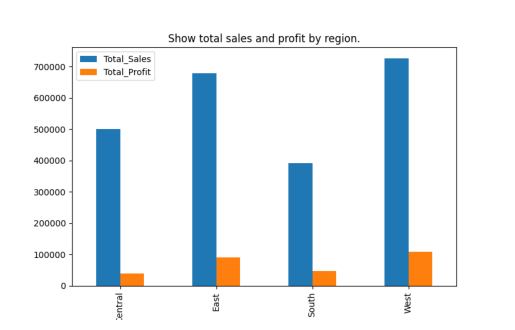

/home/azureuser/divakar_projects/NN_DL/results/region_result_20250828_193539.png


📊 Yearly Sales (from results/yearly_result_20250828_193539.png)


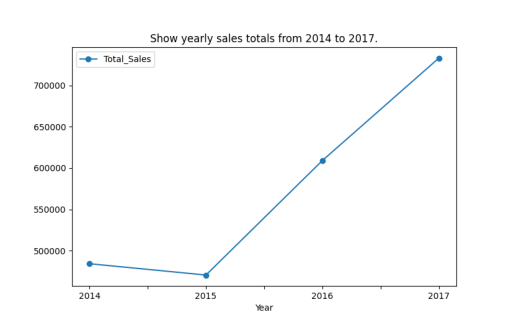

/home/azureuser/divakar_projects/NN_DL/results/yearly_result_20250828_193539.png

In [68]:
#Inline Gallery + CSV Previews + FileLinks

import pandas as pd
import matplotlib.pyplot as plt
import os
from IPython.display import FileLink

print("📊 Quick Results & File Previews")

# 1. Preview latest summary CSV
summary_files = sorted([f for f in os.listdir("results") if f.startswith("batch_results_summary_")])
if summary_files:
    latest_summary = summary_files[-1]
    print(f"\n📄 Summary Preview ({latest_summary}):")
    summary_df = pd.read_csv(os.path.join("results", latest_summary))
    display(summary_df.head())
    display(FileLink(os.path.join("results", latest_summary)))
else:
    print("⚠️ No summary CSV found.")

# 2. Preview latest individual query CSVs
query_files = sorted([f for f in os.listdir("results") if f.startswith("query_") and f.endswith(".csv")])
if query_files:
    print("\n📂 Individual Query CSV Previews:")
    for f in query_files[-3:]:  # show last 3 queries
        print(f"\n➡️ Preview of {f}:")
        q_df = pd.read_csv(os.path.join("results", f))
        display(q_df.head())
        display(FileLink(os.path.join("results", f)))
else:
    print("⚠️ No individual query CSVs found.")

# 3. Show latest Region chart
region_charts = sorted([f for f in os.listdir("results") if f.startswith("region_result_")])
if region_charts:
    latest_region_chart = os.path.join("results", region_charts[-1])
    print(f"\n📊 Sales & Profit by Region (from {latest_region_chart})")
    img = plt.imread(latest_region_chart)
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    display(FileLink(latest_region_chart))

# 4. Show latest Yearly chart
yearly_charts = sorted([f for f in os.listdir("results") if f.startswith("yearly_result_")])
if yearly_charts:
    latest_yearly_chart = os.path.join("results", yearly_charts[-1])
    print(f"\n📊 Yearly Sales (from {latest_yearly_chart})")
    img = plt.imread(latest_yearly_chart)
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    display(FileLink(latest_yearly_chart))


In [70]:
#Batch Run NL Queries + Export Each Result

from datetime import datetime
import matplotlib.pyplot as plt

# Make sure results folder exists
os.makedirs("results", exist_ok=True)

# Timestamp for unique exports
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Define batch NL queries
nl_queries = [
    "Show total sales and profit by region.",
    "List the top 10 customers by total sales.",
    "Show profitability (profit margin) by product category.",
    "Show yearly sales totals from 2014 to 2017.",
    "Analyze how discount levels impact average profit."
]

batch_results = []

for i, q in enumerate(nl_queries, 1):
    print("="*100)
    print("📝 NL Query:", q)

    sql, latency = hf_nl_to_sql(q)
    print("SQL:", sql)

    result = run_sql(sql)

    # Save individual query result to CSV if it's a DataFrame
    if isinstance(result, pd.DataFrame) and not result.empty:
        query_csv = f"results/query_{i}_{timestamp}.csv"
        result.to_csv(query_csv, index=False)
        preview = result.head(3).to_dict()  # smaller preview
    else:
        query_csv = "ERROR"
        preview = str(result)

    # Save summary entry
    batch_results.append({
        "NL_Query": q,
        "Generated_SQL": sql,
        "Execution_Result_Preview": preview,
        "Result_File": query_csv,
        "Latency (s)": round(latency, 2)
    })

    # Save chart for region/year queries
    if isinstance(result, pd.DataFrame) and not result.empty:
        if "region" in q.lower():
            fig_path = f"results/region_result_{timestamp}.png"
            result.plot(x=result.columns[0], y=result.columns[1:], kind="bar", figsize=(8,5))
            plt.title(q)
            plt.savefig(fig_path)
            plt.close()

        if "yearly" in q.lower():
            fig_path = f"results/yearly_result_{timestamp}.png"
            result.plot(x=result.columns[0], y=result.columns[1], kind="line", marker="o", figsize=(8,5))
            plt.title(q)
            plt.savefig(fig_path)
            plt.close()

# Export summary CSV
summary_csv = f"results/batch_results_summary_{timestamp}.csv"
pd.DataFrame(batch_results).to_csv(summary_csv, index=False)

print(f"\n✅ Batch run completed. Summary saved to {summary_csv}")
print("Each query result also exported separately in the results/ folder.")


📝 NL Query: Show total sales and profit by region.
SQL: SELECT Region, SUM(Sales) AS Total_Sales, SUM(Profit) AS Total_Profit FROM superstore GROUP BY Region;
📝 NL Query: List the top 10 customers by total sales.
SQL: SELECT [Customer Name], SUM(Sales) AS Total_Sales FROM superstore GROUP BY [Customer Name] ORDER BY Total_Sales DESC LIMIT 10;
📝 NL Query: Show profitability (profit margin) by product category.
SQL: SELECT Category, SUM(Profit)/SUM(Sales) AS Profit_Margin FROM superstore GROUP BY Category;
📝 NL Query: Show yearly sales totals from 2014 to 2017.
SQL: SELECT strftime('%Y', [Order Date]) AS Year, SUM(Sales) AS Total_Sales FROM superstore GROUP BY Year ORDER BY Year;
📝 NL Query: Analyze how discount levels impact average profit.
SQL: SELECT Discount, AVG(Profit) AS Avg_Profit FROM superstore GROUP BY Discount ORDER BY Discount;

✅ Batch run completed. Summary saved to results/batch_results_summary_20250828_194615.csv
Each query result also exported separately in the results/

In [71]:
#Preview + Download Batch Summary

import pandas as pd
import os
from IPython.display import FileLink

print("📊 Batch Run Summary Preview")

# Find latest summary CSV
summary_files = sorted([f for f in os.listdir("results") if f.startswith("batch_results_summary_")])
if summary_files:
    latest_summary = summary_files[-1]
    latest_path = os.path.join("results", latest_summary)
    print(f"\nShowing {latest_summary}:")
    
    # Preview first 5 rows
    df_summary = pd.read_csv(latest_path)
    display(df_summary.head())
    
    # Download link
    display(FileLink(latest_path))
else:
    print("⚠️ No summary CSV found in results folder.")


📊 Batch Run Summary Preview

Showing batch_results_summary_20250828_194615.csv:


,NL_Query,Generated_SQL,Execution_Result_Preview,Result_File,Latency (s)
0,Show total sales and profit by region.,"SELECT Region, SUM(Sales) AS Total_Sales, SUM(...","{'Region': {0: 'Central', 1: 'East', 2: 'South...",results/query_1_20250828_194615.csv,0.64
1,List the top 10 customers by total sales.,"SELECT [Customer Name], SUM(Sales) AS Total_Sa...","{'Customer Name': {0: 'Sean Miller', 1: 'Tamar...",results/query_2_20250828_194615.csv,3.86
2,Show profitability (profit margin) by product ...,"SELECT Category, SUM(Profit)/SUM(Sales) AS Pro...","{'Category': {0: 'Furniture', 1: 'Office Suppl...",results/query_3_20250828_194615.csv,1.06
3,Show yearly sales totals from 2014 to 2017.,"SELECT strftime('%Y', [Order Date]) AS Year, S...","{'Year': {0: '2014', 1: '2015', 2: '2016'}, 'T...",results/query_4_20250828_194615.csv,3.35
4,Analyze how discount levels impact average pro...,"SELECT Discount, AVG(Profit) AS Avg_Profit FRO...","{'Discount': {0: 0.0, 1: 0.1, 2: 0.15}, 'Avg_P...",results/query_5_20250828_194615.csv,0.90


/home/azureuser/divakar_projects/NN_DL/results/batch_results_summary_20250828_194615.csv